In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from opxrd.wrapper import OpXRD

test_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final/HKUST'
full_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final'
database = OpXRD.load_project_list(root_dirpath=test_dirpath)

100% (21 of 21) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 10% (51 of 499) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01

- Loading databases from /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST


100% (499 of 499) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


In [5]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=database, output_dirpath='/tmp/opxrd_analysis')

---> Combined pattern plot for databaes ['a:HKUST-A', 'b:HKUST-B'] | No. patterns = 50

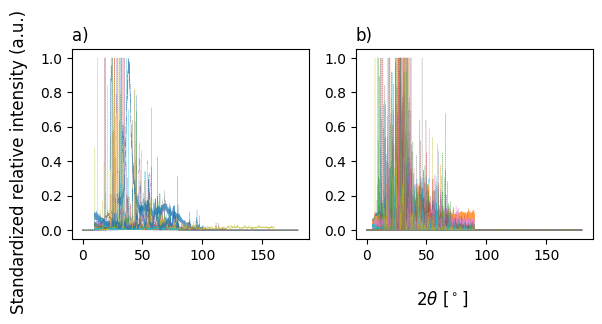

In [6]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for HKUST-A | No. patterns = 21
[Debug]: Performing PCA for HKUST-B | No. patterns = 499


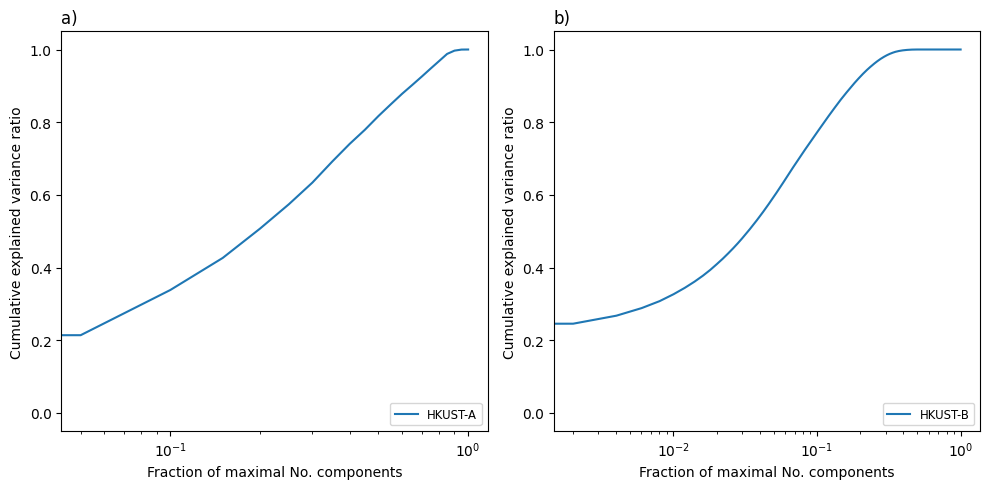

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for HKUST-A | No. patterns = 21
[Debug]: Performing PCA for HKUST-B | No. patterns = 499


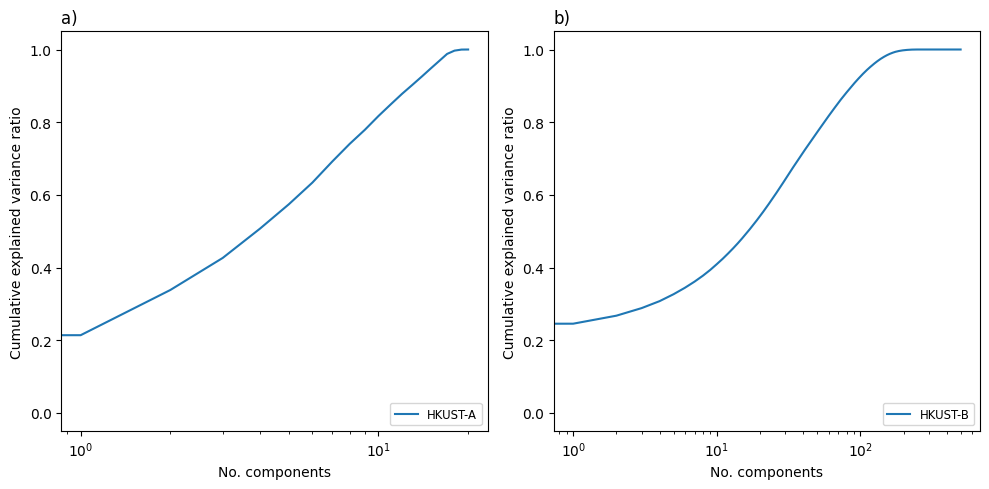

In [7]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

IndexError: list index out of range

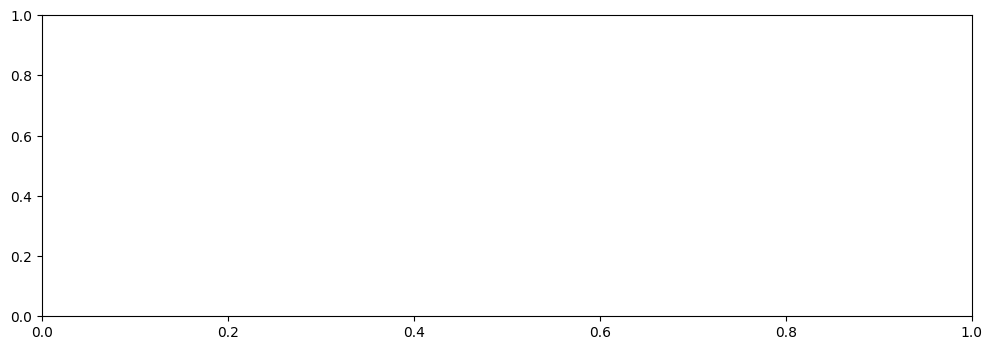

In [9]:
analyser.show_histograms()

In [16]:
analyser.show_label_fractions()
analyser.print_total_counts()

---> Overview of label fractions per contribution

+---------+----------------+----------+-----------+---------------+---------------+
|         |   No. patterns |      spg |   lattice |   atom_coords |   composition |
|---------+----------------+----------+-----------+---------------+---------------|
| EMPA    |            770 | 0.631169 |  0        |      0        |      0.997403 |
| LBNL-A  |          28765 | 0        |  0        |      0        |      0        |
| LBNL-B  |            342 | 0        |  0        |      0        |      0        |
| LBNL-C  |          39557 | 0        |  0        |      0        |      0        |
| LBNL-D  |           1348 | 0        |  0        |      0        |      0        |
| USC     |            338 | 1        |  0.899408 |      0        |      1        |
| INT     |          19796 | 0        |  0        |      0        |      0        |
| HKUST-A |            499 | 0        |  0        |      0        |      0        |
| HKUST-B |             21 | 1        |  1        |      1        |      0  

---> Total pattern counts in opXRD

Total number of patterns = 92552
Number of labeled patterns = 2179
